In [1]:
library(Seurat)
library(tximport)
library(dplyr)
library(ggplot2)
library(ggsci)
library(tidyverse)
library(pheatmap)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.3     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
files <- file.path("/data/Matthew/scrna/sc_align/osativa_salmon_leaf1/alevin/quants_mat.gz")
txi <- tximport(files, type = "alevin")
osa_obj <- CreateSeuratObject(counts = txi$counts, project = "osa_shoot1")

reading in alevin gene-level counts across cells with fishpond

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


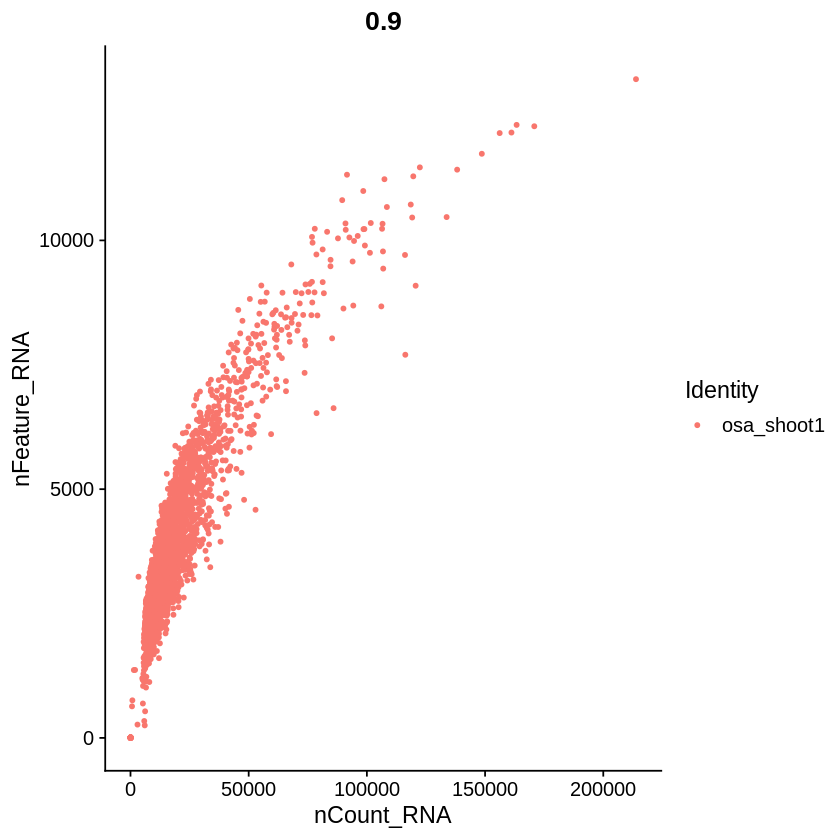

In [3]:
id_path <- "/data/Matthew/scrna/02.Clustering/id_latest/"
FeatureScatter(osa_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

In [5]:
options(warn = -1)

osa_obj <- osa_obj %>%
#     NormalizeData() %>%
#     FindVariableFeatures() %>%
#     ScaleData(vars.to.regress = c("CC.Difference"), verbose = F) %>%
    SCTransform(vars.to.regress = "nCount_RNA", verbose = FALSE) %>%
    RunPCA(npc = 100, verbose = F) %>%
#    RunTSNE(dims = 1:50) %>%
    RunUMAP(dims = 1:100, verbose = F) %>%
    FindNeighbors(dims = 1:100, verbose = F) %>%
    FindClusters(resolution = 0.75, verbose = F) %>%
    identity()
options(warn = 1)
table(osa_obj@active.ident)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13 
747 528 514 373 354 307 286 215 200 160 152 103  81  30 

In [6]:
osa_obj <- osa_obj %>%
    FindNeighbors(dims = 1:100, verbose = F) %>%
    FindClusters(resolution = 0.75, verbose = F) %>%
    identity()
table(osa_obj@active.ident)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13 
747 528 514 373 354 307 286 215 200 160 152 103  81  30 

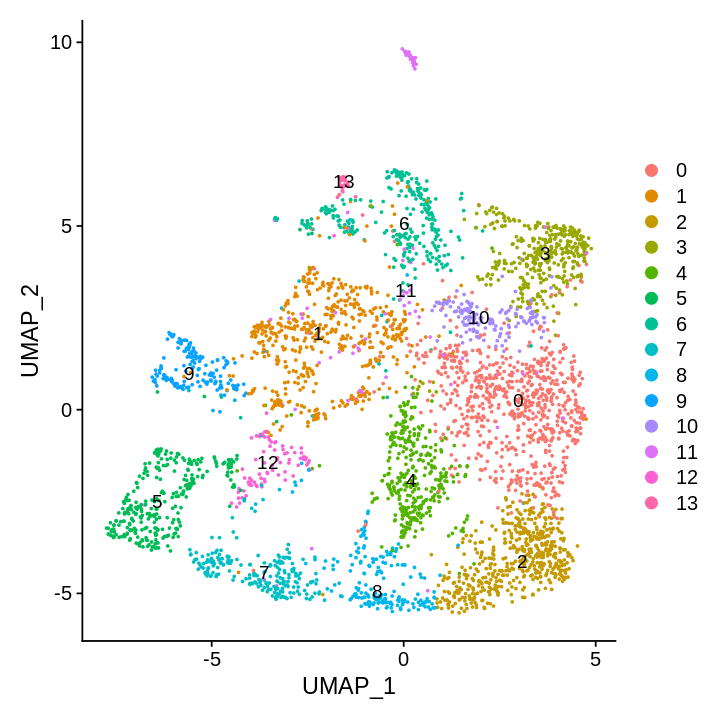

In [7]:
options(repr.plot.height = 6, repr.plot.width = 6)
p1 <- DimPlot(object = osa_obj, reduction = "umap", label = T)
p1

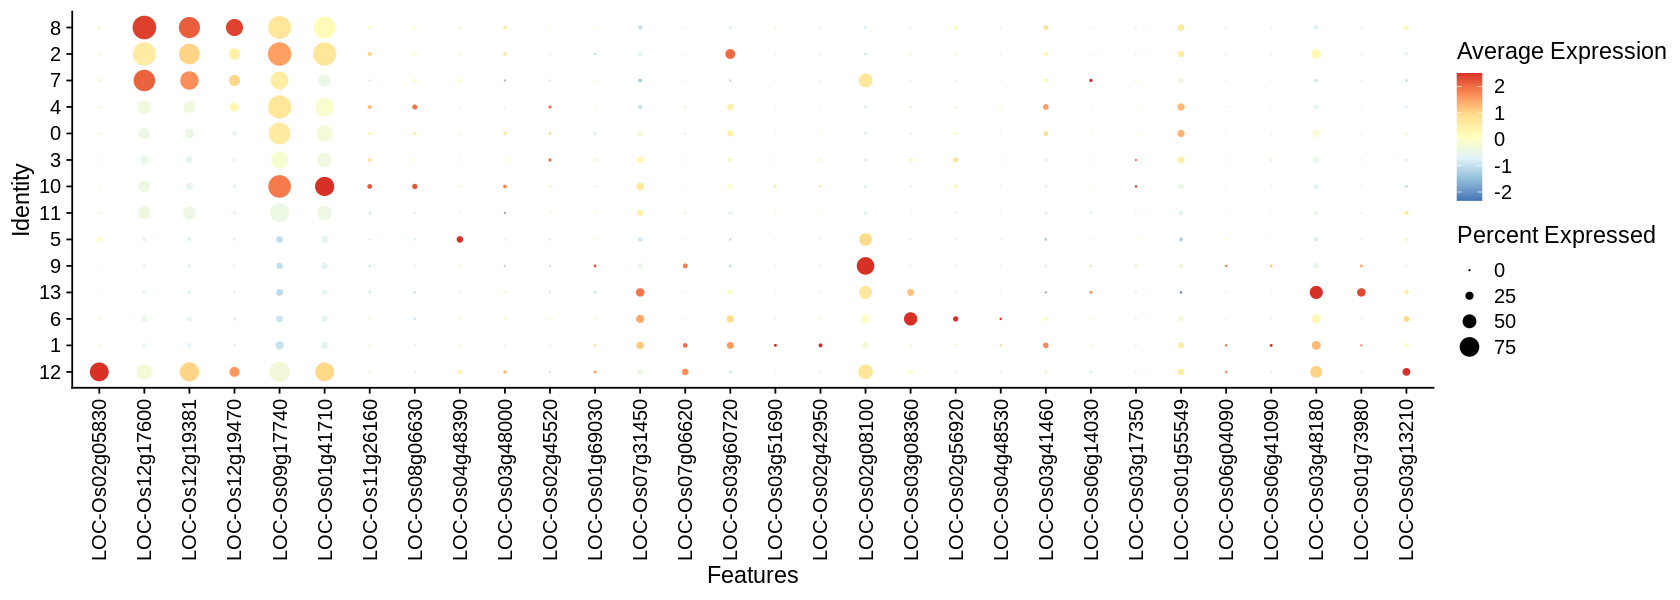

In [8]:
options(repr.plot.height = 5, repr.plot.width = 14)

celltype <- readLines(paste(id_path, "osa_celltype.id",sep = "/"))
p2 <- DotPlot(osa_obj, features = celltype, cluster.idents = T, cols = "RdYlBu") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
p2

In [9]:
options(repr.plot.height = 6, repr.plot.width = 8)

new.cluster.ids <- c("MC", "Phloem", "MC", "MC", "MC", 
                     "MC", "Epidermis", "MC", "MC", "Procambium", 
                     "Initial", "MC", "Mestome", "Xylem")

# Add seurat object levels to new.cluster.ids 
names(new.cluster.ids) <- levels(osa_obj)
# Rename clusters
osa_obj <- RenameIdents(osa_obj, new.cluster.ids) 

osa_obj[["old.ident"]] <- Idents(object = osa_obj)
# t-SNE plot
# options(repr.plot.height = 6, repr.plot.width = 6)

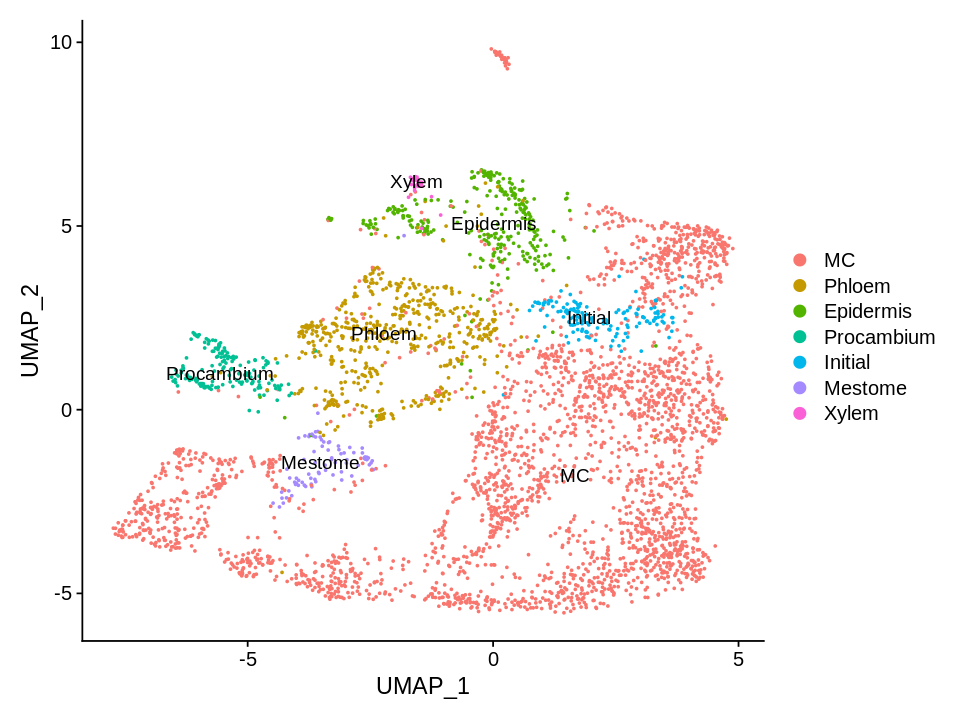

In [10]:
p3 <- DimPlot(osa_obj, reduction = "umap", label = TRUE)
p3

In [11]:
osa_exp <- AverageExpression(osa_obj)
osa_exp$RNA %>% head()

Warning message in PseudobulkExpression(object = object, pb.method = "average", :
“Exponentiation yielded infinite values. `data` may not be log-normed.”


,MC,Phloem,Epidermis,Procambium,Initial,Mestome,Xylem
ChrUn.fgenesh.gene.1,0.053237322,0.070678275,0.10645105,0.03221778,0.06782691,0.1637307,0
ChrUn.fgenesh.gene.10,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000,0
ChrUn.fgenesh.gene.11,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000,0
ChrUn.fgenesh.gene.12,0.003515411,0.029600732,0.01201596,0.02147852,0.00000000,0.0000000,0
ChrUn.fgenesh.gene.13,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.0000000,0
ChrUn.fgenesh.gene.14,0.002443344,0.009762965,0.00000000,0.00000000,0.00000000,0.0000000,0


In [12]:
osa_index <- osa_exp$RNA %>%
  as.data.frame() %>%
  rownames_to_column(var = "osa_id") %>%
  as_tibble() %>%
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(MC:Xylem)) / 5,
    Phloem_osa = Phloem / mean_gC,
    Xylem_osa = Xylem / mean_gC,
    MC_osa = MC / mean_gC,
    EC_osa = Epidermis / mean_gC,
    Procambium_osa = Procambium / mean_gC,
    Initial_osa = Initial / mean_gC,
    Mestome_osa = Mestome / mean_gC,
  ) %>%
  select(osa_id, Phloem_osa:Mestome_osa) %>% drop_na() %>%
  identity()

In [13]:
head(osa_index)

osa_id,Phloem_osa,Xylem_osa,MC_osa,EC_osa,Procambium_osa,Initial_osa,Mestome_osa
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ChrUn.fgenesh.gene.1,0.7151616,0.0000000,0.5386844,1.077130,0.3259972,0.6863099,1.6567167
ChrUn.fgenesh.gene.12,2.2219228,0.0000000,0.2638777,0.901955,1.6122446,0.0000000,0.0000000
ChrUn.fgenesh.gene.14,3.9991470,0.0000000,1.0008530,0.000000,0.0000000,0.0000000,0.0000000
ChrUn.fgenesh.gene.15,0.0000000,0.0000000,0.4258222,4.574178,0.0000000,0.0000000,0.0000000
ChrUn.fgenesh.gene.19,0.0000000,0.0000000,0.3399405,1.671770,2.9882893,0.0000000,0.0000000
ChrUn.fgenesh.gene.21,1.0553097,0.1653915,1.8140492,1.065363,0.0310109,0.3053838,0.5634918


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3005
Number of edges: 99853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8354
Number of communities: 6
Elapsed time: 0 seconds


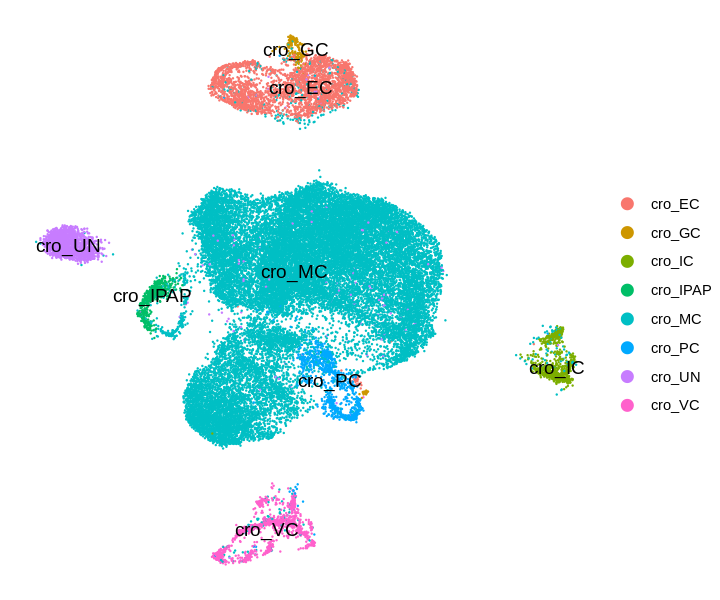

In [14]:
options(repr.plot.height = 5, repr.plot.width = 6)
load(file = "/data/Matthew/scrna/02.Clustering/crov7_alv_mincell5.Rdata")
# new cluster names
new.cluster.ids <- c("MC", "MC", "MC", "MC", "MC",
                     "MC", "EC", "UN", "VC", "EC",
                     "PC", "IC", "IPAP", "MC")

# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)
seurat_obj[["old.ident"]] <- Idents(object = seurat_obj)

# find sub clusters
for (i in c("EC")) {
  seurat_obj <- FindSubCluster(seurat_obj, cluster = i,
                               graph.name = "RNA_snn",
                               resolution = 0.4,
                               algorithm = 1)
  sub_name <- as.factor(seurat_obj@meta.data$sub.cluster)
  names(sub_name) <- names(seurat_obj@active.ident)
  seurat_obj@active.ident <- sub_name
}
# add name to clusters
seurat_obj[["seurat_clusters"]] <- seurat_obj@active.ident
# new cluster names
new.cluster.ids <- paste("cro_",
    c("EC", "EC", "EC", "EC", "EC", "GC",
      "IC", "IPAP", "MC", "PC", "UN", "VC"), sep = "")
# Add seurat object levels to new.cluster.ids
names(new.cluster.ids) <- levels(seurat_obj)
# Rename clusters
seurat_obj <- RenameIdents(seurat_obj, new.cluster.ids)

DimPlot(seurat_obj, reduction = "umap", label = TRUE) + theme_void()

In [15]:
cro_exp <- AverageExpression(seurat_obj)
cro_index <- cro_exp$RNA %>%
  as.data.frame() %>% 
  rownames_to_column(var = "cro_id") %>% 
  as_tibble() %>% 
  rowwise() %>%
  mutate(
    mean_gC = sum(c_across(cro_EC:cro_VC)) / 8,
    MC_cro = cro_MC / mean_gC,
    UN_cro = cro_UN / mean_gC,
    PC_cro = cro_PC / mean_gC,
    IPAP_cro = cro_IPAP / mean_gC,
    IC_cro = cro_IC / mean_gC,
    EC_cro = cro_EC / mean_gC,
    VC_cro = cro_VC / mean_gC,
    GC_cro = cro_GC / mean_gC
  ) %>%
  select(cro_id, MC_cro:GC_cro) %>% 
  identity()

rbh <- read.table(paste(id_path, 'cro_osa.rbh.tsv',sep = '/'), col.names = c("cro_id", "osa_id")) %>% as_tibble()

cro_sub_index <- left_join(rbh, cro_index)
osa_sub_index <- left_join(rbh, osa_index)

cor_spearman <-
  left_join(cro_sub_index, osa_sub_index) %>% 
  select(-c("cro_id", "osa_id")) %>%
  drop_na() %>%
  cor(method = "spearman") %>%
  identity()

Joining, by = "cro_id"

Joining, by = "osa_id"

Joining, by = c("cro_id", "osa_id")



In [16]:
cor_spearman

,MC_cro,UN_cro,PC_cro,IPAP_cro,IC_cro,EC_cro,VC_cro,GC_cro,Phloem_osa,Xylem_osa,MC_osa,EC_osa,Procambium_osa,Initial_osa,Mestome_osa
MC_cro,1.00000000,0.60242525,0.017529692,0.42865417,0.289365142,-0.05249577,-0.378959914,-0.33912104,-0.1430701369,0.0283634246,0.17333664,-0.03239110,0.033290961,0.018933582,0.151686475
UN_cro,0.60242525,1.00000000,-0.034425315,0.34861232,0.265460188,-0.08149662,-0.327873773,-0.26697087,-0.0861663244,0.0414989480,0.09612431,-0.08722067,0.012321130,-0.040037395,0.086822578
PC_cro,0.01752969,-0.03442531,1.000000000,0.01882531,-0.035725681,-0.28845105,-0.025712387,-0.17966779,0.0243185380,-0.0811990948,0.11182067,0.03452990,-0.076425004,0.274046169,0.009592112
IPAP_cro,0.42865417,0.34861232,0.018825306,1.00000000,0.216233316,-0.21891951,-0.191755113,-0.22598821,-0.0716127097,0.0637129738,0.13711877,-0.07486276,0.025834183,0.004939130,0.101997429
IC_cro,0.28936514,0.26546019,-0.035725681,0.21623332,1.000000000,-0.18209716,-0.159808266,-0.28109896,-0.0078235751,0.0506953348,0.06756610,-0.08504745,-0.009199626,0.010477570,0.082378177
EC_cro,-0.05249577,-0.08149662,-0.288451054,-0.21891951,-0.182097156,1.00000000,-0.088506082,0.27970707,-0.0156925619,0.1011174575,-0.07050941,0.15531699,0.112807184,-0.082615608,0.011306862
VC_cro,-0.37895991,-0.32787377,-0.025712387,-0.19175511,-0.159808266,-0.08850608,1.000000000,-0.00364303,0.2439574418,0.0394338591,-0.08691718,0.02399739,0.026676316,0.001801252,-0.077712090
GC_cro,-0.33912104,-0.26697087,-0.179667790,-0.22598821,-0.281098958,0.27970707,-0.003643030,1.00000000,0.0303616844,0.1418858341,-0.02548641,0.16487354,0.119733764,0.037875358,0.041185690
Phloem_osa,-0.14307014,-0.08616632,0.024318538,-0.07161271,-0.007823575,-0.01569256,0.243957442,0.03036168,1.0000000000,0.0002430534,-0.41026886,0.05448221,0.081995630,0.134165161,0.009494068
Xylem_osa,0.02836342,0.04149895,-0.081199095,0.06371297,0.050695335,0.10111746,0.039433859,0.14188583,0.0002430534,1.0000000000,-0.08102335,0.15449594,0.318041530,0.025179062,0.252745998


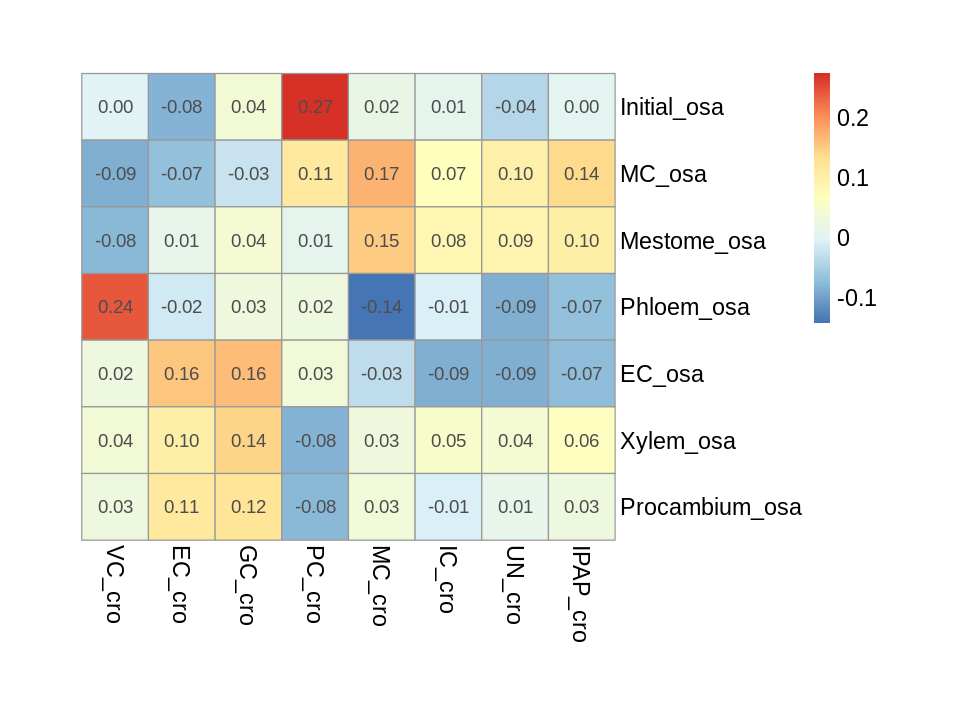

In [17]:
options(repr.plot.height = 6, repr.plot.width = 8)
pheatmap(cor_spearman[9:15, 1:8],
         display_numbers = T,
         fontsize = 14,
         treeheight_row = 0,
         treeheight_col = 0,
         cellwidth = 40,
         cellheight = 40,
         )

In [13]:
pheatmap(cor_spearman[9:13, 1:8],
         display_numbers = F,
         fontsize = 14,
         treeheight_row = 0,
         treeheight_col = 0,
         cellwidth = 40,
         cellheight = 40,
         filename = "leaf_compare_cor.pdf")

In [14]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/Matthew/miniconda3/envs/psdtime/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12    forcats_0.5.1      stringr_1.4.0      purrr_0.3.4       
 [5] readr_1.4.0        tidyr_1.1.3        tibble_3.1.3       tidyverse_1.3.1   
 [9] ggsci_2.9          ggplot2_3.3.5      dplyr_1.0.7        tximport_1.18.0   
[13] SeuratObject_4.0.2 Seurat_4.0.3      

loaded via a